In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
!pip install bioinfokit

In [4]:
### readin
data27 = pd.read_excel('ABBREV27.xlsx')
data27_group = pd.read_csv('nndb_flat.csv')

len(data27)

8618

In [5]:
data27.head()

,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Choline_Tot_ (mg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,1.5,60.0,7.0,51.368,21.021,3.043,215.0,5.0,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1,1002,"BUTTER,WHIPPED,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.16,2.0,23.0,26.0,659.0,0.05,0.016,0.004,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.13,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,1.5,60.0,7.0,50.489,23.426,3.012,219.0,3.0,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,1.8,73.0,8.6,61.924,28.732,3.694,256.0,12.0,1 tbsp,205.0,1 cup,0.0
3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0,28.0,1 oz,17.0,1 cubic inch,0.0
4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0,132.0,"1 cup, diced",113.0,"1 cup, shredded",0.0


In [6]:
data27_group.foodgroup.unique()

array(['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods',
       'Fats and Oils', 'Poultry Products', 'Soups, Sauces, and Gravies',
       'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Snacks',
       'Fruits and Fruit Juices', 'Pork Products',
       'Vegetables and Vegetable Products', 'Nut and Seed Products',
       'Beef Products', 'Beverages', 'Finfish and Shellfish Products',
       'Legumes and Legume Products', 'Lamb, Veal, and Game Products',
       'Baked Products', 'Sweets', 'Cereal Grains and Pasta',
       'Fast Foods', 'Meals, Entrees, and Side Dishes',
       'American Indian/Alaska Native Foods', 'Restaurant Foods'],
      dtype=object)

In [7]:
#### introduction of the original data (screenshot is ok)

In [8]:
#### data preprocessing

### join with label 'food group'
data27.insert(1, 'Food_Group', data27_group['foodgroup'], allow_duplicates=False)
data27.head(5)

,NDB_No,Food_Group,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Choline_Tot_ (mg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,1.5,60.0,7.0,51.368,21.021,3.043,215.0,5.0,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.16,2.0,23.0,26.0,659.0,0.05,0.016,0.004,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.13,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,1.5,60.0,7.0,50.489,23.426,3.012,219.0,3.0,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,1.8,73.0,8.6,61.924,28.732,3.694,256.0,12.0,1 tbsp,205.0,1 cup,0.0
3,1004,Dairy and Egg Products,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0,28.0,1 oz,17.0,1 cubic inch,0.0
4,1005,Dairy and Egg Products,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0,132.0,"1 cup, diced",113.0,"1 cup, shredded",0.0


In [9]:
len(set(data27['Food_Group']))

25

In [10]:
### drop non-numerical columns
### drop non-important columns
data27=data27.drop(labels=['GmWt_Desc1','GmWt_Desc2'],axis=1)
data27=data27.drop(labels=['Water_(g)'],axis=1)
data27.head(5)

,NDB_No,Food_Group,Shrt_Desc,Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Choline_Tot_ (mg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2,Refuse_Pct
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT",717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,1.5,60.0,7.0,51.368,21.021,3.043,215.0,5.0,14.2,0.0
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT",717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.16,2.0,23.0,26.0,659.0,0.05,0.016,0.004,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.13,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,1.5,60.0,7.0,50.489,23.426,3.012,219.0,3.0,9.4,0.0
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,1.8,73.0,8.6,61.924,28.732,3.694,256.0,12.0,205.0,0.0
3,1004,Dairy and Egg Products,"CHEESE,BLUE",353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0,28.0,17.0,0.0
4,1005,Dairy and Egg Products,"CHEESE,BRICK",371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0,132.0,113.0,0.0


In [11]:
### missing data

# drop columns with missing data > 3.5k
data27=data27.drop(labels=list(data27.columns[data27.isna().sum()>3500]), axis=1)

# missing data imputation with mean value of the same group
for column in list(data27.columns[data27.isna().sum()>0]):
    data27[column] = data27.groupby('Food_Group')[column].transform(lambda x: x.fillna(x.mean()))
    
# missing data imputation with 0
#data27.fillna(value=0)

data27.head(5)

,NDB_No,Food_Group,Shrt_Desc,Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,Refuse_Pct
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT",717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,1.5,60.0,51.368,21.021,3.043,215.0,5.0,0.0
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT",717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.16,2.0,23.0,26.0,659.0,0.05,0.016,0.004,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,0.13,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,1.5,60.0,50.489,23.426,3.012,219.0,3.0,0.0
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,1.8,73.0,61.924,28.732,3.694,256.0,12.0,0.0
3,1004,Dairy and Egg Products,"CHEESE,BLUE",353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,18.669,7.778,0.800,75.0,28.0,0.0
4,1005,Dairy and Egg Products,"CHEESE,BRICK",371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,18.764,8.598,0.784,94.0,132.0,0.0


In [12]:
### VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)
selector.fit_transform(data27[list(data27.columns)[3:]])

# View the variance of each feature
selector.variances_ ,len(selector.variances_)

(array([9.02000000e+02, 8.83200000e+01, 1.00000000e+02, 8.87796454e+00,
        1.00000000e+02, 1.86885886e+01, 9.98000000e+01, 7.36400000e+03,
        3.27343824e+01, 7.81000000e+02, 9.91800000e+03, 1.65000000e+04,
        3.87580000e+04, 1.11241377e+01, 3.04000393e-01, 4.08953462e+01,
        7.91050466e+02, 2.40000000e+03, 2.67031204e-01, 1.99083019e-01,
        2.27394122e+01, 1.55291039e+00, 2.24084629e-01, 3.78600000e+03,
        2.99300000e+03, 2.34000000e+03, 5.88100000e+03, 1.89892014e+01,
        1.00000000e+05, 3.00000000e+04, 3.00000000e+04, 1.42510000e+04,
        4.28910000e+04, 6.25200000e+03, 4.62600000e+04, 1.96970000e+04,
        1.54066836e+01, 9.94853909e+00, 1.00000000e+04, 4.15722604e+01,
        4.67204133e+01, 2.53926767e+01, 3.10000000e+03, 1.17100000e+03,
        8.10000000e+01]), 45)

In [13]:
#### Data exploration

### statistics
# Selected features by some simple research, base + vitamin + minerals
# selected_features = ['Food_Group','Water_(g)', 'Energ_Kcal', 'Protein_(g)', 'Carbohydrt_(g)', 'Fiber_TD_(g)', 
#                     'Sugar_Tot_(g)','Calcium_(mg)', 'Iron_(mg)', 'Selenium_(µg)', 'Vit_C_(mg)', 
#                     'Vit_E_(mg)','Vit_A_IU', 'Vit_D_IU']
selected_features = ['Food_Group', 'Energ_Kcal', 'Protein_(g)', 'Carbohydrt_(g)', 'Fiber_TD_(g)', 
                     'Sugar_Tot_(g)','Calcium_(mg)', 'Iron_(mg)', 'Selenium_(µg)', 'Vit_C_(mg)', 
                     'Vit_E_(mg)','Vit_A_IU', 'Vit_D_IU']
data27[selected_features][1:].describe()

,Energ_Kcal,Protein_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Selenium_(µg),Vit_C_(mg),Vit_E_(mg),Vit_A_IU,Vit_D_IU
count,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000,8617.000000
mean,226.376581,11.525103,21.820543,2.227725,7.989285,77.810725,2.729809,15.599788,8.352970,1.292944,734.349194,24.741545
std,169.322172,10.550631,27.240176,4.323465,13.801513,201.110512,5.721986,28.128444,57.602369,3.925575,3720.355118,126.185888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93.000000,2.470000,0.040000,0.000000,0.005937,10.000000,0.570000,2.100000,0.000000,0.210000,0.000000,0.000000
50%,191.000000,8.290000,8.950000,0.800000,2.300000,22.000000,1.370000,11.800000,0.200000,0.450000,45.000000,3.000000
75%,336.000000,19.980000,32.900000,2.700000,8.860000,76.000000,2.620000,22.800000,3.100000,0.887700,317.596623,9.801205
max,902.000000,88.320000,100.000000,79.000000,99.800000,7364.000000,123.600000,1917.000000,2400.000000,149.400000,100000.000000,10000.000000


In [14]:
### Plot of FoodGroup-features
#Histogram, use selected features

data27_selected = data27[selected_features].groupby("Food_Group")
mean_df = data27_selected.mean()
mean_df

,Energ_Kcal,Protein_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Selenium_(µg),Vit_C_(mg),Vit_E_(mg),Vit_A_IU,Vit_D_IU
Food_Group,,,,,,,,,,,,
American Indian/Alaska Native Foods,209.115152,15.996061,11.253939,4.170588,2.700482,70.256944,4.997651,43.917808,12.646392,1.659221,3079.725806,96.882353
Baby Foods,151.991713,4.114669,21.570884,0.919355,13.989451,136.773481,3.897818,5.093983,19.187989,1.510333,835.013928,58.531056
Baked Products,391.887077,6.654831,59.767202,3.248728,19.000761,127.962963,3.051688,16.262312,0.457942,0.820466,317.596623,1.614973
Beef Products,212.749471,24.369736,0.108457,0.002854,0.000000,12.879493,2.521998,25.284825,0.380973,0.274851,266.112886,5.241087
Beverages,111.190476,2.568794,18.661905,0.865900,13.744245,84.036364,0.936728,2.984836,33.368657,1.049148,469.258555,19.574713
Breakfast Cereals,342.495868,8.298375,73.528264,7.738017,20.703428,158.337950,16.006492,17.625114,16.550278,3.099295,1226.497175,86.088561
Cereal Grains and Pasta,285.852459,9.144372,58.667158,5.640625,1.021130,38.836066,2.722842,23.795652,0.050000,0.430400,29.612717,0.213836
Dairy and Egg Products,231.534091,14.714053,11.794924,0.225670,9.316432,357.075758,0.706629,16.109375,1.772868,0.607249,574.500000,38.172414
Fast Foods,249.916442,11.714501,22.696173,1.653047,4.862137,99.097035,1.635633,18.169966,1.931563,0.887700,254.789116,5.611650


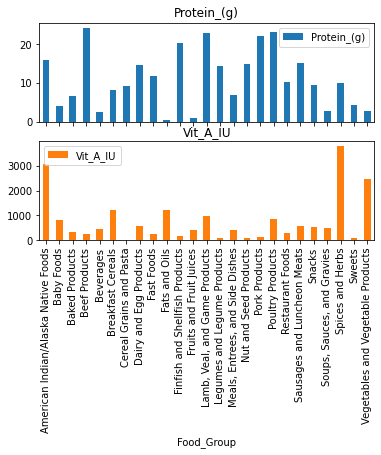

In [15]:
a = ["Protein_(g)","Vit_A_IU"]
axes = mean_df[a].plot.bar(subplots=True)
axes[1].legend(loc=2)

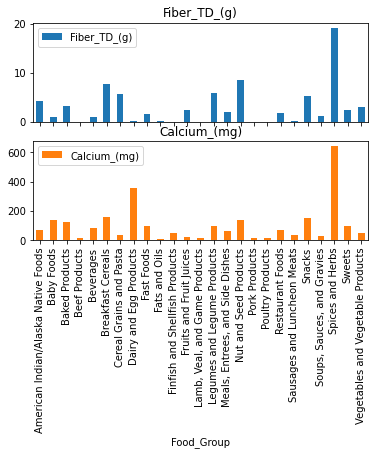

In [16]:
c = ['Fiber_TD_(g)','Calcium_(mg)']
axes3 = mean_df[c].plot.bar(subplots=True)
axes3[1].legend(loc=2)

In [17]:
#### After exploration, before PCA

### Centralization
for column in list(data27.columns)[3:]:
    #data27[column] = data27[column]-data27[column].mean()
    data27[column] = (data27[column]-data27[column].min())/(data27[column].max()-data27[column].min())

In [18]:
set(data27['Food_Group'])

{'American Indian/Alaska Native Foods',
 'Baby Foods',
 'Baked Products',
 'Beef Products',
 'Beverages',
 'Breakfast Cereals',
 'Cereal Grains and Pasta',
 'Dairy and Egg Products',
 'Fast Foods',
 'Fats and Oils',
 'Finfish and Shellfish Products',
 'Fruits and Fruit Juices',
 'Lamb, Veal, and Game Products',
 'Legumes and Legume Products',
 'Meals, Entrees, and Side Dishes',
 'Nut and Seed Products',
 'Pork Products',
 'Poultry Products',
 'Restaurant Foods',
 'Sausages and Luncheon Meats',
 'Snacks',
 'Soups, Sauces, and Gravies',
 'Spices and Herbs',
 'Sweets',
 'Vegetables and Vegetable Products'}

In [19]:
list27 = ['Beef Products','Breakfast Cereals','Cereal Grains and Pasta',
          'Dairy and Egg Products','Lamb, Veal, and Game Products',
          'Legumes and Legume Products','Pork Products','Vegetables and Vegetable Products', 
          'Poultry Products']
list28 = ['Beef Products','Breakfast Cereals','Cereal Grains and Pasta',
          'Dairy and Egg Products','Lamb, Veal, and Game Products',
          'Legumes and Legume Products','Pork Products','Vegetables and Vegetable Products',
          'Baked Products','Fast Foods','Meals, Entrees, and Side Dishes',
          'Nut and Seed Products','Poultry Products','Snacks','Soups, Sauces, and Gravies']

list_customize = ['Beef Products',
 'Breakfast Cereals',
 'Cereal Grains and Pasta',
 'Dairy and Egg Products',
 'Fats and Oils',
 'Finfish and Shellfish Products',
 'Fruits and Fruit Juices',
 'Lamb, Veal, and Game Products',
 'Legumes and Legume Products',
 'Nut and Seed Products',
 'Pork Products',
 'Poultry Products',
 'Vegetables and Vegetable Products']

data27_subgroup_15 = data27.loc[data27['Food_Group'].isin(list28)].reset_index(drop=True)
data27_subgroup_9 = data27.loc[data27['Food_Group'].isin(list27)].reset_index(drop=True)

data27_customize = data27.loc[data27['Food_Group'].isin(list_customize)].reset_index(drop=True)

print('all groups samples:', len(data27))
print('15 subgroups samples:', len(data27_subgroup_15))
print('9 subgroups samples:', len(data27_subgroup_9))
print('customized subgroups samples:', len(data27_customize))

data27.to_csv('data27_allgroup_25.csv')
data27_subgroup_15.to_csv('data27_subgroup_15.csv')
data27_subgroup_9.to_csv('data27_subgroup_9.csv')
data27_customize.to_csv('data27_customize.csv')

all groups samples: 8618
15 subgroups samples: 6181
9 subgroups samples: 4144
customized subgroups samples: 5109


In [20]:
### PCA
import plotly.express as px
from sklearn.decomposition import PCA


# sub groups 15
features = list(data27_subgroup_15.columns)[3:]

#pca = PCA(n_components='mle',svd_solver='full')
pca = PCA(n_components=10,svd_solver='full')
components = pca.fit_transform(data27_subgroup_15[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=data27_subgroup_15['Food_Group']
)
fig.update_traces(diagonal_visible=False)
fig.show()

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
px.area(x=range(0, 9),
        y=exp_var_cumul[0:9],
        labels={"x": "# Components", "y": "Explained Variance"})

In [21]:
# sub groups 9
features = list(data27_subgroup_9.columns)[3:]

#pca = PCA(n_components='mle',svd_solver='full')
pca = PCA(n_components=10,svd_solver='full')
components = pca.fit_transform(data27_subgroup_9[features])
labels = {str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)}

fig = px.scatter_matrix(components,
                        labels=labels,
                        dimensions=range(3),
                        color=data27_subgroup_9['Food_Group'])
fig.update_traces(diagonal_visible=False)
fig.show()

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
px.area(x=range(0,9),
        y=exp_var_cumul[0:9],
        labels={"x": "# Components", "y": "Explained Variance"})

In [22]:
# all groups
features = list(data27.columns)[3:]

pca = PCA(n_components='mle',svd_solver='full')
components = pca.fit_transform(data27[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=data27['Food_Group']
)
fig.update_traces(diagonal_visible=False)
fig.show()

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
px.area(x=range(0, 9),
        y=exp_var_cumul[0:9],
        labels={"x": "# Components", "y": "Explained Variance"})

In [23]:

# customized subgroups
features = list(data27_customize.columns)[3:]

pca = PCA(n_components='mle',svd_solver='full')
components = pca.fit_transform(data27_customize[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=data27_customize['Food_Group']
)
fig.update_traces(diagonal_visible=False)
fig.show()

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
px.area(x=range(0, 9),
        y=exp_var_cumul[0:9],
        labels={"x": "# Components", "y": "Explained Variance"})

In [24]:
#### PCA exploration

In [25]:
# get the component variance
# Proportion of Variance
pca = PCA(n_components=10,svd_solver='full')
#pca_out = pca.fit(data27_customize[features])
pca_out = pca.fit(data27[features])
pca_out.explained_variance_ratio_


array([0.40906765, 0.23352124, 0.09221245, 0.06086288, 0.03802151,
       0.02419192, 0.01944073, 0.01580873, 0.01395799, 0.01303228])

In [26]:
# Cumulative proportion of variance  
np.cumsum(pca_out.explained_variance_ratio_)

array([0.40906765, 0.64258888, 0.73480133, 0.79566421, 0.83368572,
       0.85787764, 0.87731837, 0.8931271 , 0.90708509, 0.92011737])

In [27]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
#loadings_df['features'] = data27_customize[features].columns.values
loadings_df['features'] = data27[features].columns.values
loadings_df = loadings_df.set_index('features')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
features,,,,,,,,,,
Energ_Kcal,0.418435,0.538584,0.077335,0.076629,0.044294,-0.155910,0.029712,0.083389,0.039045,0.007639
Protein_(g),-0.102173,0.157500,0.460302,0.524246,0.447171,-0.305302,-0.138364,0.067585,0.026362,-0.078837
Lipid_Tot_(g),0.121277,0.621482,-0.175358,-0.129861,-0.071453,0.116284,-0.015767,0.035626,-0.013793,0.069335
Ash_(g),0.015541,-0.000766,0.014273,0.058668,-0.005740,0.034766,-0.052701,-0.085492,-0.013540,0.026816
Carbohydrt_(g),0.808535,-0.319678,0.175302,0.041778,-0.237222,-0.199113,0.066329,0.037206,0.089480,-0.017195
Fiber_TD_(g),0.072841,-0.030497,0.044579,0.130761,-0.209581,0.185094,-0.280923,-0.085364,0.025376,0.152097
Sugar_Tot_(g),0.301897,-0.132862,-0.023150,-0.426899,0.741252,0.301174,-0.215052,0.010051,-0.073488,-0.050682
Calcium_(mg),0.020062,-0.002263,0.010514,0.043749,0.010329,0.073870,-0.055243,-0.047643,-0.033483,0.066370
Iron_(mg),0.048947,-0.014057,0.074057,0.154103,-0.037388,0.229690,0.096083,0.004134,-0.158166,0.090345


In [28]:
sum(loadings_df["PC1"])

1.920818052156542

In [29]:
loadings_df1 = loadings_df.round(3)
#loadings_df1 = loadings_df1.loc[selected_features[1:]]

In [30]:
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.metrics import r2_score

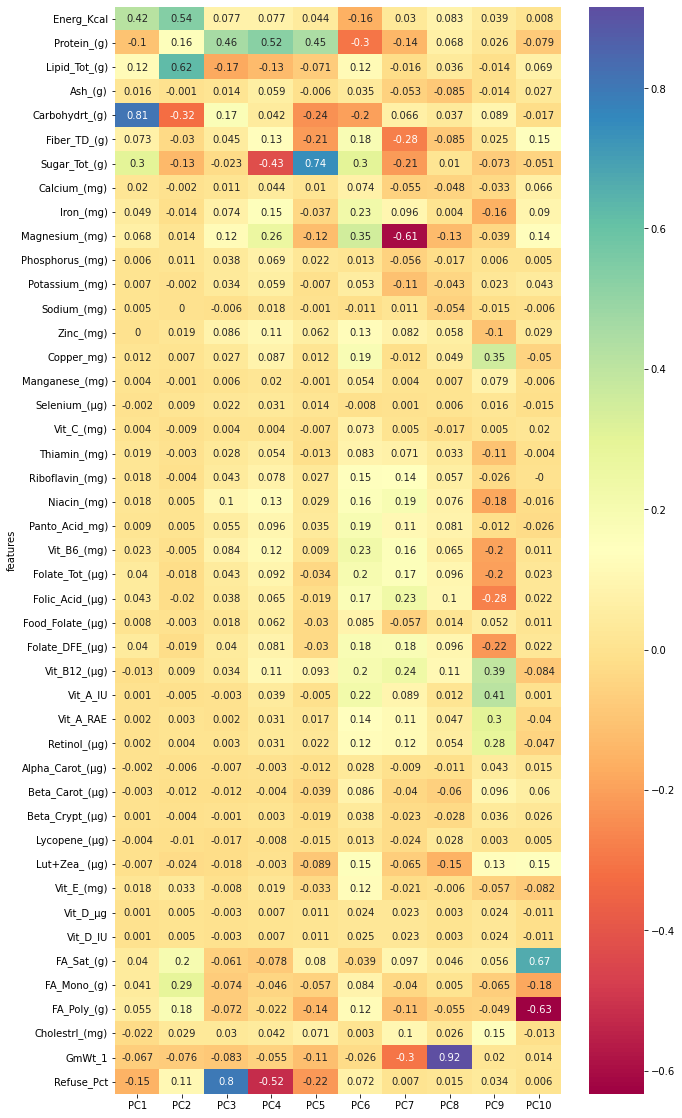

In [31]:
plt.figure(figsize=(10,20))
ax = sns.heatmap(loadings_df1, annot=True, cmap='Spectral')
plt.show()

In [32]:
new_selectf = ['Energ_Kcal','Calcium_(mg)','Phosphorus_(mg)',
       'Potassium_(mg)', 'Sodium_(mg)','Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)',
       'Folate_DFE_(µg)','Vit_A_IU', 'Vit_A_RAE','Retinol_(µg)', 'Alpha_Carot_(µg)', 
       'Beta_Carot_(µg)','Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_D_IU']

In [33]:
# import matplotlib.font_manager
# from bioinfokit.visuz import cluster
# cluster.screeplot(obj=[pc_list[:10], pca_out.explained_variance_ratio_])
# from IPython.display import display, Image
# display(Image(filename='screeplot.png'))

In [34]:
### rose plot for PCx-feature
# get 2D biplot
# from bioinfokit.visuz import cluster
# cluster.biplot(cscore=components, loadings=loadings, labels=data27_subgroup_9[features].columns.values, 
#                var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
#               var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

In [35]:
!pip install pyecharts

     |████████████████████████████████| 135 kB 4.7 MB/s 
     |████████████████████████████████| 130 kB 7.3 MB/s 


In [36]:
# rose plot

from pyecharts.charts import Pie
from pyecharts import options as opts

num = loadings_df1['PC1']
num = abs(num)
# color_series = ['#FAE927','#E9E416','#C9DA36','#9ECB3C','#6DBC49',
#                 '#37B44E','#3DBA78','#14ADCF','#209AC9','#1E91CA',
#                 '#2C6BA0','#2B55A1','#2D3D8E','#44388E','#6A368B'
#                 '#7D3990','#A63F98','#C31C88','#D52178','#D5225B',
#                 '#D02C2A','#D44C2D','#F57A34','#FA8F2F','#D99D21',
#                 '#CF7B25','#CF7B25','#CF7B25']
color_series = ['#C9DA36','#6DBC49','#3DBA78','#209AC9',
                '#2C6BA0','#2D3D8E','#6A368B','#A63F98','#D52178',
                '#D02C2A','#F57A34','#FA8F2F','#D99D21']


#descending
df = pd.DataFrame({'features': features, 'num': num})
df.sort_values(by='num', ascending=False, inplace=True)

v = df['features'].values.tolist()
d = df['num'].values.tolist()

v=v[:10]
d=d[:10]

pie1 = Pie(init_opts=opts.InitOpts(width='1350px', height='750px'))
pie1.set_colors(color_series)
pie1.add("", [list(z) for z in zip(v, d)],
        radius=["30%", "125%"],
        center=["50%", "65%"],
        rosetype="area")

pie1.set_global_opts(title_opts=opts.TitleOpts(title='rose plot'),
                     legend_opts=opts.LegendOpts(is_show=False),
                     toolbox_opts=opts.ToolboxOpts())

pie1.set_series_opts(label_opts=opts.LabelOpts(is_show=True, position="inside", font_size=17,
                                               formatter="{b}:{c}", font_style="italic",
                                               font_weight="bold", font_family="Microsoft YaHei"
                                               ))
# 生成html文档
pie1.render('rose plot.html')

'/content/rose plot.html'

In [37]:
# from IPython.display import display, Image
# display(Image(filename='biplot_2d.png'))

In [38]:
### Clustering
from sklearn.cluster import KMeans

# Use elbow point to get the best K
distortions = []
K = range(1,12)

for cluster_size in K:
    kmeans = KMeans(n_clusters=cluster_size, init='k-means++')
    kmeans = kmeans.fit(components)
    distortions.append(kmeans.inertia_)
    
df = pd.DataFrame({'Clusters': K, 'Distortions': distortions})
fig = (px.line(df, x='Clusters', y='Distortions', template='seaborn')).update_traces(mode='lines+markers')
fig.show()

In [39]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
         ("pca", PCA(n_components=2, random_state=42)),
    ]
)

clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters = 4,
               init = "k-means++",
               n_init = 50,
               max_iter = 1000,
               random_state = 42,
           ),
       ),
   ]
)

pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

pipe.fit(components)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=1000, n_clusters=4, n_init=50,
                                         random_state=42))]))])

In [40]:
preprocessed_data = pipe["preprocessor"].transform(components)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.4979717349503062

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



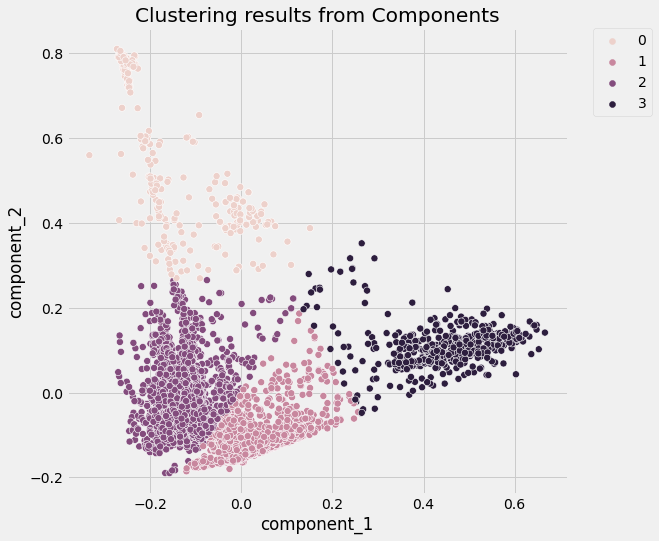

In [41]:
# k-means clustering
label_encoder = LabelEncoder()
pcadf = pd.DataFrame(
      pipe["preprocessor"].transform(components),
      columns=["component_1", "component_2"],)
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf = pcadf[["component_1","component_2","predicted_cluster"]]

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster")

scat.set_title(
   "Clustering results from Components")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [42]:
#pca_merged = pcadf.join(data27_customize)
pca_merged = pcadf.join(data27)
pca_merged.head(5)

,component_1,component_2,predicted_cluster,NDB_No,Food_Group,Shrt_Desc,Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,Refuse_Pct
0,-0.215044,0.576068,0,1001,Dairy and Egg Products,"BUTTER,WITH SALT",0.794900,0.009624,0.8111,0.021142,0.0006,0.0,0.000601,0.003259,0.000162,0.002561,0.002420,0.001455,0.016590,0.000990,0.000000,0.000000,0.000522,0.0,0.000214,0.001943,0.000329,0.003188,0.000250,0.000792,0.0,0.001282,0.000510,0.001719,0.02499,0.022800,0.022367,0.0,0.003684,0.0,0.0,0.0,0.015529,0.0060,0.0060,0.537322,0.251180,0.040778,0.069355,0.004270,0.0
1,-0.216782,0.580110,0,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT",0.794900,0.009624,0.8111,0.021142,0.0006,0.0,0.000601,0.003259,0.001294,0.002561,0.002319,0.001576,0.017003,0.000550,0.001063,0.000012,0.000522,0.0,0.000214,0.001943,0.000329,0.003188,0.000250,0.000792,0.0,0.001282,0.000510,0.001315,0.02499,0.022800,0.022367,0.0,0.003684,0.0,0.0,0.0,0.015529,0.0060,0.0060,0.528128,0.279917,0.040363,0.070645,0.002562,0.0
2,-0.255750,0.746053,0,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",0.971175,0.003170,0.9948,0.000000,0.0000,0.0,0.000000,0.000543,0.000000,0.000000,0.000302,0.000303,0.000052,0.000110,0.000066,0.000000,0.000000,0.0,0.000043,0.000286,0.000024,0.000290,0.000083,0.000000,0.0,0.000000,0.000000,0.000101,0.03069,0.028000,0.027467,0.0,0.004500,0.0,0.0,0.0,0.018742,0.0072,0.0073,0.647741,0.343319,0.049502,0.082581,0.010248,0.0
3,-0.109432,0.147397,2,1004,Dairy and Egg Products,"CHEESE,BLUE",0.391353,0.242301,0.2874,0.051202,0.0234,0.0,0.005010,0.071700,0.002508,0.029449,0.039020,0.015515,0.029568,0.029247,0.002658,0.000027,0.007564,0.0,0.001241,0.021829,0.007969,0.050116,0.013833,0.009509,0.0,0.015385,0.006121,0.012337,0.00721,0.006600,0.006400,0.0,0.001725,0.0,0.0,0.0,0.001673,0.0020,0.0021,0.195282,0.092939,0.010721,0.024194,0.023911,0.0
4,-0.112051,0.156425,2,1005,Dairy and Egg Products,"CHEESE,BRICK",0.411308,0.263134,0.2968,0.031864,0.0279,0.0,0.005110,0.091526,0.003479,0.030730,0.045473,0.008242,0.014449,0.028587,0.001595,0.000037,0.007564,0.0,0.000599,0.020057,0.000925,0.008348,0.005417,0.005283,0.0,0.008547,0.003401,0.012741,0.01080,0.009733,0.009533,0.0,0.001772,0.0,0.0,0.0,0.001740,0.0020,0.0022,0.196276,0.102738,0.010506,0.030323,0.112724,0.0


In [43]:
b = selected_features + ["predicted_cluster"]
pca_df = pca_merged[b].groupby("predicted_cluster")
mean_df_pca = pca_df.mean()
mean_df_pca

,Energ_Kcal,Protein_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Selenium_(µg),Vit_C_(mg),Vit_E_(mg),Vit_A_IU,Vit_D_IU
predicted_cluster,,,,,,,,,,,,
0,0.203971,0.138396,0.128780,0.042661,0.037336,0.013466,0.032571,0.009572,0.004711,0.011087,0.010419,0.002113
1,0.191086,0.083267,0.244440,0.041863,0.093925,0.010487,0.031205,0.006047,0.005555,0.009543,0.009275,0.002198
2,0.234341,0.136628,0.102654,0.021536,0.039982,0.010573,0.018431,0.007887,0.003500,0.012651,0.007988,0.005107
3,0.186887,0.173496,0.088007,0.009944,0.052675,0.008588,0.016020,0.009542,0.005946,0.003257,0.009132,0.001464


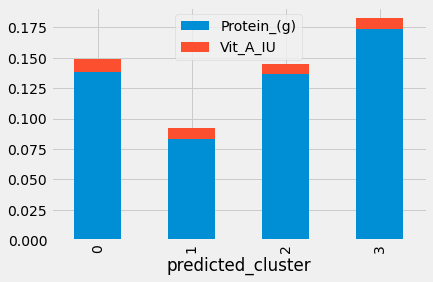

In [44]:
axes = mean_df_pca[a].plot.bar(stacked=True)
axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bd736a150>,
      dtype=object)

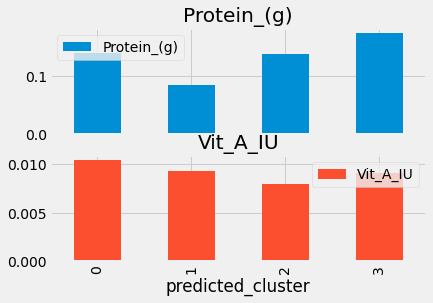

In [45]:
axes2 = mean_df_pca[['Protein_(g)', 'Vit_A_IU']].plot.bar(subplots=True)
axes2

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bd62b9b50>,
      dtype=object)

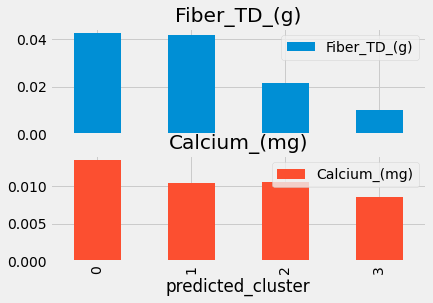

In [46]:
axes4 = mean_df_pca[['Fiber_TD_(g)','Calcium_(mg)']].plot.bar(subplots=True)
axes4

In [47]:
pca_merged.to_csv('pca_merged.csv')

In [48]:
print(pca_merged.groupby('predicted_cluster').size())
print(pca_merged.groupby(['predicted_cluster', 'Food_Group']).size())

predicted_cluster
0     325
1    1838
2    2336
3     610
dtype: int64
predicted_cluster  Food_Group                       
0                  Baby Foods                           103
                   Beef Products                         11
                   Beverages                              3
                   Dairy and Egg Products                 8
                   Fats and Oils                          4
                   Finfish and Shellfish Products         6
                   Lamb, Veal, and Game Products          2
                   Legumes and Legume Products           15
                   Nut and Seed Products                 10
                   Pork Products                         86
                   Sausages and Luncheon Meats           11
                   Soups, Sauces, and Gravies             5
                   Spices and Herbs                      45
                   Vegetables and Vegetable Products     16
1                  Baby Foods       

In [49]:
pca_merged.groupby('predicted_cluster').size().to_frame().rename(columns={0:'count'}).reset_index()

,predicted_cluster,count
0,0,325
1,1,1838
2,2,2336
3,3,610


In [50]:
pd.set_option('display.max_rows', None)
pca_merged.groupby(['predicted_cluster', 'Food_Group']).size().to_frame().rename(columns={0:'count'}).reset_index()


,predicted_cluster,Food_Group,count
0,0,Baby Foods,103
1,0,Beef Products,11
2,0,Beverages,3
3,0,Dairy and Egg Products,8
4,0,Fats and Oils,4
5,0,Finfish and Shellfish Products,6
6,0,"Lamb, Veal, and Game Products",2
7,0,Legumes and Legume Products,15
8,0,Nut and Seed Products,10
9,0,Pork Products,86


In [51]:
#### Others, no need

In [52]:
# data exploration
# summary statistics of the data set
data27.describe()

,NDB_No,Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,Refuse_Pct
count,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000
mean,15467.757368,0.251035,0.130479,0.106470,0.018478,0.218180,0.028196,0.080044,0.010566,0.022083,0.045359,0.016539,0.017159,0.008234,0.022740,0.013414,0.002205,0.008137,0.003480,0.009513,0.014312,0.028222,0.018732,0.023691,0.013226,0.008523,0.010585,0.011668,0.014126,0.007346,0.003762,0.002960,0.002223,0.005131,0.001759,0.004423,0.009937,0.008655,0.002472,0.002475,0.036963,0.047682,0.029765,0.013253,0.081761,0.062178
std,9221.428766,0.187799,0.119459,0.158665,0.029857,0.272396,0.054725,0.138286,0.027308,0.046292,0.071433,0.020155,0.022619,0.024489,0.036674,0.036637,0.019498,0.014673,0.024000,0.022108,0.025498,0.037403,0.036123,0.039450,0.034331,0.036334,0.024684,0.033133,0.044068,0.037202,0.025978,0.025662,0.018228,0.024873,0.020374,0.025769,0.047312,0.026274,0.012617,0.012618,0.067448,0.081679,0.067532,0.038194,0.070327,0.149208
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8695.250000,0.103104,0.027966,0.009925,0.008818,0.000400,0.000000,0.000059,0.001358,0.004612,0.016768,0.005848,0.008121,0.001084,0.004398,0.004053,0.000067,0.001095,0.000000,0.001840,0.004000,0.004951,0.006467,0.005250,0.001585,0.000000,0.002137,0.001020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001406,0.000000,0.000000,0.002437,0.003241,0.003136,0.000000,0.024765,0.000000
50%,14273.000000,0.211752,0.093807,0.052350,0.012525,0.089450,0.010127,0.023046,0.002988,0.011084,0.028169,0.014519,0.014000,0.002322,0.010335,0.006821,0.000518,0.006155,0.000083,0.003636,0.009543,0.020157,0.013188,0.012500,0.003790,0.000000,0.004579,0.002626,0.002779,0.000450,0.000333,0.000067,0.000000,0.000117,0.000000,0.000000,0.000328,0.003012,0.000400,0.000300,0.016736,0.023079,0.009436,0.001613,0.072588,0.000000
75%,20050.750000,0.372506,0.226195,0.139000,0.023246,0.329000,0.034177,0.088753,0.010320,0.021197,0.040973,0.022068,0.020470,0.010630,0.030456,0.011628,0.001843,0.011894,0.001292,0.010396,0.015213,0.039843,0.021065,0.030333,0.011740,0.001297,0.009829,0.010877,0.016180,0.003176,0.002000,0.001018,0.000200,0.001110,0.000316,0.000050,0.003087,0.005942,0.000988,0.000980,0.045246,0.058308,0.028007,0.021613,0.110162,0.000000
max,93600.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,

In [53]:
# data27_subgroup_15.describe()
data27_subgroup_9.describe()

,NDB_No,Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,Refuse_Pct
count,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000
mean,14083.953185,0.217126,0.181064,0.085092,0.015809,0.143141,0.026704,0.035235,0.008768,0.026386,0.046897,0.018955,0.019288,0.005279,0.033458,0.014719,0.001876,0.009178,0.003081,0.011369,0.017860,0.037439,0.022854,0.033401,0.017700,0.011968,0.013420,0.015963,0.019616,0.009065,0.004856,0.004063,0.002998,0.007232,0.001391,0.002956,0.016051,0.005337,0.001689,0.001693,0.032307,0.039776,0.015327,0.020035,0.082855,0.110952
std,7569.828391,0.140108,0.123673,0.109221,0.014912,0.252258,0.055617,0.082917,0.021614,0.049200,0.062534,0.013784,0.017546,0.009638,0.036863,0.047111,0.021238,0.009300,0.019359,0.027632,0.030883,0.042116,0.039436,0.046050,0.045757,0.050093,0.028572,0.044887,0.054189,0.043400,0.032636,0.032399,0.024555,0.031367,0.015435,0.031381,0.063787,0.019782,0.004338,0.004342,0.049535,0.054840,0.025749,0.052202,0.055132,0.180115
min,1001.000000,0.003326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10071.750000,0.124169,0.057405,0.010950,0.009018,0.000000,0.000000,0.000000,0.001222,0.006958,0.023047,0.009780,0.012182,0.001213,0.007449,0.004651,0.000043,0.001513,0.000000,0.002481,0.006114,0.008010,0.010145,0.009979,0.001585,0.000000,0.002564,0.001020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001138,0.000000,0.000000,0.002436,0.003035,0.003297,0.000000,0.047822,0.000000
50%,11979.500000,0.194013,0.204201,0.051400,0.011022,0.016900,0.000000,0.002004,0.002309,0.013673,0.029449,0.018855,0.017394,0.001780,0.024849,0.006977,0.000151,0.008738,0.000000,0.003722,0.011231,0.032882,0.018110,0.023579,0.003038,0.000000,0.004701,0.002040,0.007377,0.000140,0.000133,0.000033,0.000000,0.000012,0.000000,0.000000,0.000000,0.001941,0.000400,0.000500,0.015727,0.023133,0.007344,0.018710,0.072588,0.000000
75%,17284.250000,0.299335,0.278787,0.114525,0.015832,0.146125,0.035443,0.035054,0.005839,0.022492,0.038412,0.022890,0.021576,0.006141,0.047966,0.012691,0.001439,0.013772,0.001292,0.010139,0.016816,0.049875,0.026896,0.039833,0.010037,0.000000,0.010407,0.007822,0.025179,0.001980,0.001320,0.000379,0.000013,0.000513,0.000032,0.000000,0.003579,0.004522,0.000988,0.000980,0.040630,0.055518,0.016309,0.026774,0.107739,0.197531
max,48052.000000,0.995565,1.000000,0.995000,0.230762,0.913000,1.000000,0.746092,0.452607,0.547492,1.000000,0.169087,0.381818,0.175964,0.707312,1.000000,1.000000,0.162493,0.791667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.338889,1.000000,0.970776,0.943980,0.943967,0.943967,1.000000,1.000000,0.555182

In [54]:
['Water_(g)', 'Energ_Kcal', 'Protein_(g)', 'Lipid_Tot_(g)',
       'Ash_(g)', 'Carbohydrt_(g)', 'Fiber_TD_(g)', 'Sugar_Tot_(g)',
       'Calcium_(mg)', 'Iron_(mg)', 'Magnesium_(mg)', 'Phosphorus_(mg)',
       'Potassium_(mg)', 'Sodium_(mg)', 'Zinc_(mg)', 'Copper_mg)',
       'Manganese_(mg)', 'Selenium_(µg)', 'Vit_C_(mg)', 'Thiamin_(mg)',
       'Riboflavin_(mg)', 'Niacin_(mg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)',
       'Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)',
       'Folate_DFE_(µg)', 'Vit_B12_(µg)', 'Vit_A_IU', 'Vit_A_RAE',
       'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)',
       'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)',
       'Vit_D_µg', 'Vit_D_IU', 'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)',
       'Cholestrl_(mg)', 'GmWt_1', 'Refuse_Pct']

['Water_(g)',
 'Energ_Kcal',
 'Protein_(g)',
 'Lipid_Tot_(g)',
 'Ash_(g)',
 'Carbohydrt_(g)',
 'Fiber_TD_(g)',
 'Sugar_Tot_(g)',
 'Calcium_(mg)',
 'Iron_(mg)',
 'Magnesium_(mg)',
 'Phosphorus_(mg)',
 'Potassium_(mg)',
 'Sodium_(mg)',
 'Zinc_(mg)',
 'Copper_mg)',
 'Manganese_(mg)',
 'Selenium_(µg)',
 'Vit_C_(mg)',
 'Thiamin_(mg)',
 'Riboflavin_(mg)',
 'Niacin_(mg)',
 'Panto_Acid_mg)',
 'Vit_B6_(mg)',
 'Folate_Tot_(µg)',
 'Folic_Acid_(µg)',
 'Food_Folate_(µg)',
 'Folate_DFE_(µg)',
 'Vit_B12_(µg)',
 'Vit_A_IU',
 'Vit_A_RAE',
 'Retinol_(µg)',
 'Alpha_Carot_(µg)',
 'Beta_Carot_(µg)',
 'Beta_Crypt_(µg)',
 'Lycopene_(µg)',
 'Lut+Zea_ (µg)',
 'Vit_E_(mg)',
 'Vit_D_µg',
 'Vit_D_IU',
 'FA_Sat_(g)',
 'FA_Mono_(g)',
 'FA_Poly_(g)',
 'Cholestrl_(mg)',
 'GmWt_1',
 'Refuse_Pct']